In [1]:
import numpy as np
from trace_IO import *
from TraceSimulator import TraceSimulator
import matplotlib.pyplot as plt
from OptimumFilter import *


In [2]:
# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and all PSDs
template = np.load("./sub_ch_template.npy")
mmc_psd = np.load("../../templates/noise_psd_from_MMC.npy")

Processing noise files...
Processing blue...
Processing brownian...
Processing mmc...
Processing pink...
Processing violet...
Processing white...


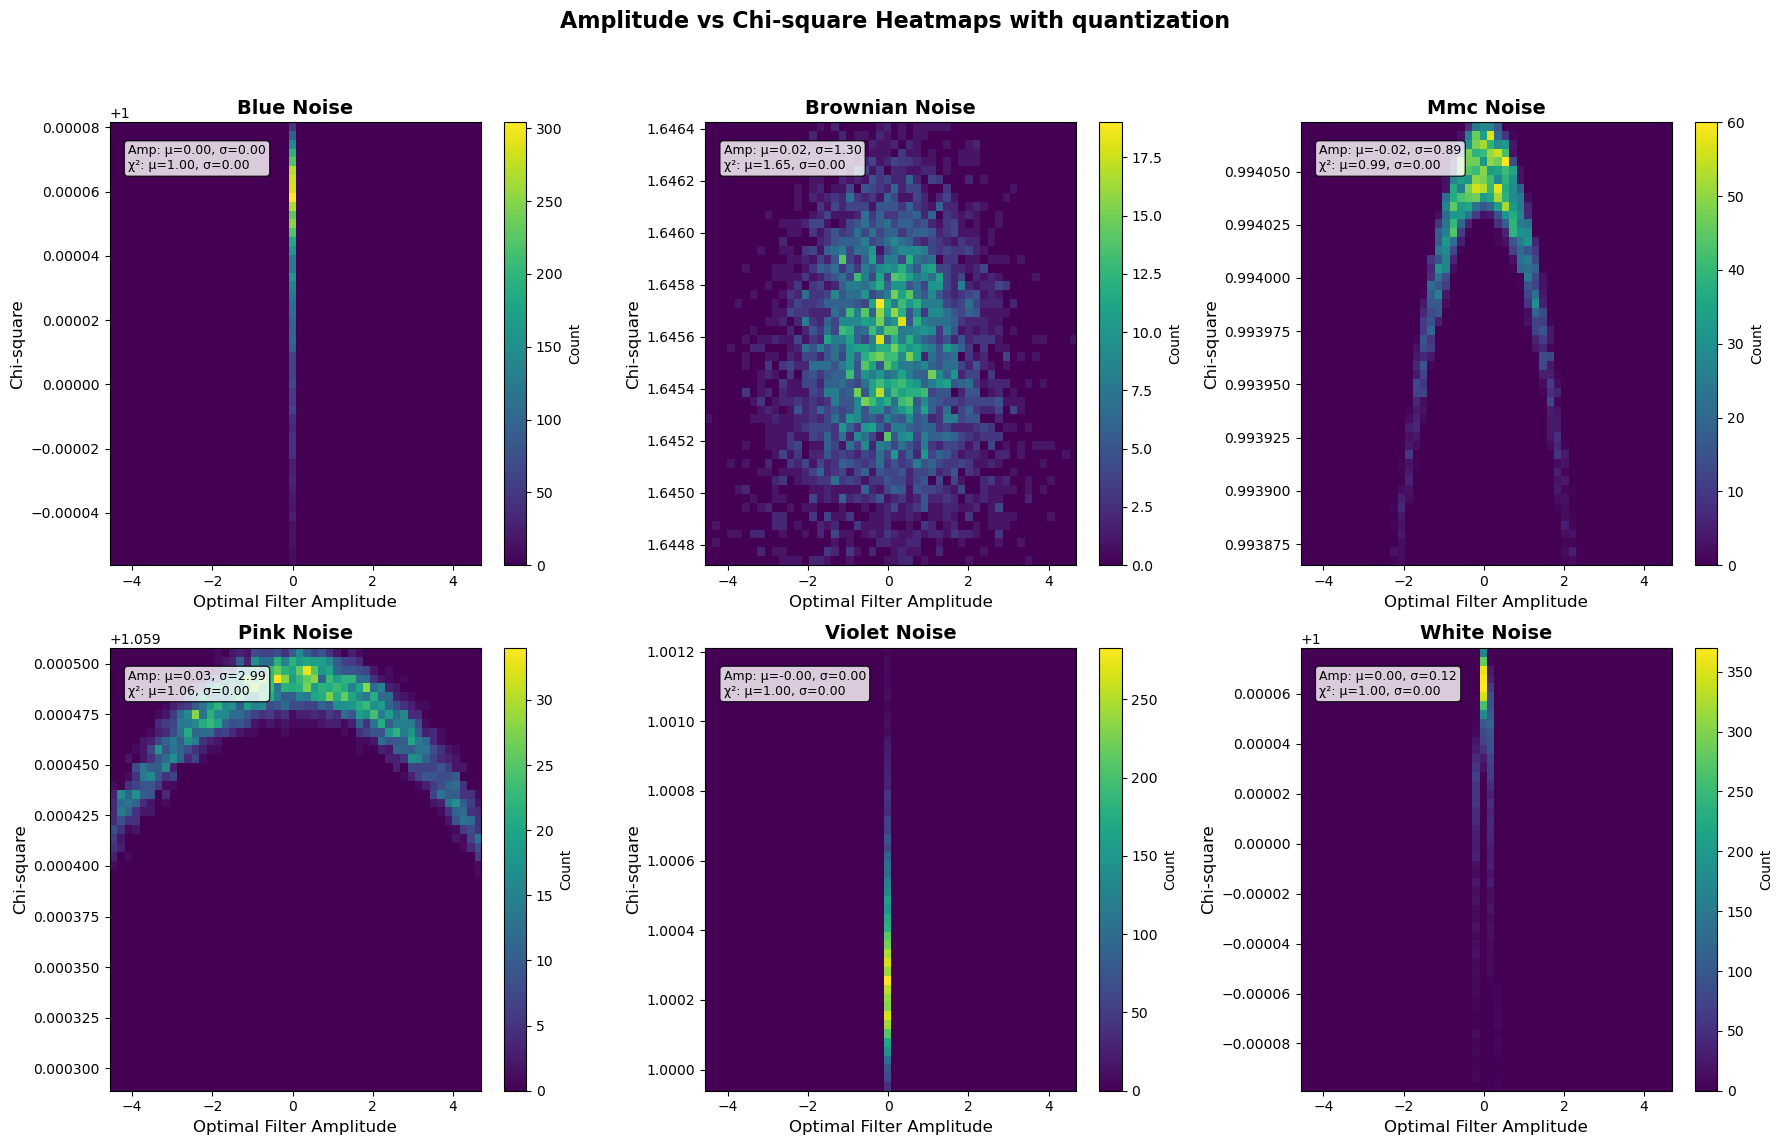


SUMMARY STATISTICS
Noise Type   Amp Mean   Amp Std    χ² Mean    χ² Std     N Points  
--------------------------------------------------------------------------------
blue         0.000      0.002      1.000      0.000      5400      
brownian     0.019      1.305      1.646      0.000      5400      
mmc          -0.018     0.888      0.994      0.000      5400      
pink         0.030      2.988      1.059      0.000      5400      
violet       -0.000     0.000      1.000      0.000      5400      
white        0.000      0.122      1.000      0.000      5400      


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde

# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and all PSDs
template = np.load("./sub_ch_template.npy")
mmc_psd = np.load("../../templates/noise_psd_from_MMC.npy")
brownian_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_brownian.npy")
white_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_white.npy")
blue_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_blue.npy")
pink_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_pink.npy")
violet_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_violet.npy")

# Initialize filters
mmc_trigger = OptimumFilter(template, mmc_psd, sampling_frequency)
brownian_trigger = OptimumFilter(template, brownian_psd, sampling_frequency)
white_trigger = OptimumFilter(template, white_psd, sampling_frequency)
blue_trigger = OptimumFilter(template, blue_psd, sampling_frequency)
pink_trigger = OptimumFilter(template, pink_psd, sampling_frequency)
violet_trigger = OptimumFilter(template, violet_psd, sampling_frequency)

# Map labels to corresponding triggers
trigger_map = {
    'mmc': mmc_trigger,
    'brownian': brownian_trigger,
    'white': white_trigger,
    'blue': blue_trigger,
    'pink': pink_trigger,
    'violet': violet_trigger,
}

# Color mapping - using same colormap for both heatmaps and scatter plots
color_map = {
    'white': 'Greys',
    'pink': 'Reds',
    'brownian': 'copper',
    'blue': 'Blues',
    'violet': 'Purples',
    'mmc': 'Reds',
}

# Process and collect amplitude and chi-square statistics
def process_noise_file(filepath, label):
    trigger = trigger_map[label]
    traces = load_traces_from_zstd(filepath, n_traces=100)
    amplitudes = []
    chisquares = []

    for trace_idx, trace_set in enumerate(traces):
        for ch in range(54):
            amp, chisq = trigger.fit(trace_set[ch])
            amplitudes.append(amp)
            chisquares.append(chisq)
    
    return np.array(amplitudes), np.array(chisquares)

# Define noise files
noise_dir = "/ceph/dwong/trigger_samples/noise_traces_w_o_quanization"
noise_files = [
    "blue_noise_traces.zst",
    "brownian_noise_traces.zst",
    "mmc_noise_traces.zst",
    "pink_noise_traces.zst",
    "violet_noise_traces.zst",
    "white_noise_traces.zst",
]

# Collect amplitudes and chi-squares for all noise types
all_data = {}

print("Processing noise files...")
for filename in noise_files:
    full_path = os.path.join(noise_dir, filename)
    label = filename.replace("_noise_traces.zst", "")
    print(f"Processing {label}...")
    amplitudes, chisquares = process_noise_file(full_path, label)
    all_data[label] = {'amplitudes': amplitudes, 'chisquares': chisquares}

# Create heatmaps - one plot for each noise type
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Find global x-range for consistent amplitude scaling
all_amps = np.concatenate([data['amplitudes'] for data in all_data.values()])
amp_range = [np.percentile(all_amps, 1), np.percentile(all_amps, 99)]

for idx, (label, data) in enumerate(all_data.items()):
    ax = axes[idx]
    amplitudes = data['amplitudes']
    chisquares = data['chisquares']
    
    # Individual y-range for each subplot (zoomed in)
    chisq_range = [np.percentile(chisquares, 1), np.percentile(chisquares, 99)]
    
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(amplitudes, chisquares, 
                                         bins=50, 
                                         range=[amp_range, chisq_range])
    
    # Plot heatmap using 'viridis' colormap for all
    im = ax.imshow(hist.T, origin='lower', aspect='auto', 
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')
    
    ax.set_title(f'{label.capitalize()} Noise', fontsize=14, fontweight='bold')
    ax.set_xlabel('Optimal Filter Amplitude', fontsize=12)
    ax.set_ylabel('Chi-square', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Count', fontsize=10)
    
    # Add statistics text
    mean_amp = np.mean(amplitudes)
    std_amp = np.std(amplitudes)
    mean_chisq = np.mean(chisquares)
    std_chisq = np.std(chisquares)
    
    stats_text = f'Amp: μ={mean_amp:.2f}, σ={std_amp:.2f}\nχ²: μ={mean_chisq:.2f}, σ={std_chisq:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=9)

plt.suptitle('Amplitude vs Chi-square Heatmaps with quantization', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"{'Noise Type':<12} {'Amp Mean':<10} {'Amp Std':<10} {'χ² Mean':<10} {'χ² Std':<10} {'N Points':<10}")
print("-"*80)

for label, data in all_data.items():
    amp_mean = np.mean(data['amplitudes'])
    amp_std = np.std(data['amplitudes'])
    chisq_mean = np.mean(data['chisquares'])
    chisq_std = np.std(data['chisquares'])
    n_points = len(data['amplitudes'])
    
    print(f"{label:<12} {amp_mean:<10.3f} {amp_std:<10.3f} {chisq_mean:<10.3f} {chisq_std:<10.3f} {n_points:<10}")

In [11]:
print("\n" + "="*80)
print("SAMPLE CHI-SQUARE VALUES (First 20 per noise type)")
print("="*80)

for label, data in all_data.items():
    chisquares = data['chisquares']
    sample_chisq = chisquares[:20]  # First 20 values
    formatted = ", ".join([f"{x:.3f}" for x in sample_chisq])
    print(f"{label.capitalize():<12}: {formatted}")



SAMPLE CHI-SQUARE VALUES (First 20 per noise type)
Blue        : 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000
Brownian    : 1.646, 1.645, 1.646, 1.645, 1.646, 1.645, 1.646, 1.646, 1.645, 1.645, 1.645, 1.646, 1.645, 1.645, 1.646, 1.645, 1.646, 1.646, 1.646, 1.646
Mmc         : 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994
Pink        : 1.059, 1.059, 1.059, 1.059, 1.060, 1.059, 1.060, 1.059, 1.059, 1.059, 1.059, 1.059, 1.059, 1.059, 1.059, 1.059, 1.059, 1.059, 1.059, 1.059
Violet      : 1.000, 1.000, 1.000, 1.000, 1.001, 1.000, 1.000, 1.001, 1.000, 1.000, 1.001, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.001, 1.001, 1.000
White       : 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000
